# Churn Prediction Challenge Code

- Predict whether a user will churn after his/her subscription expires. Specifically, we want to forecast if a user make a new service subscription transaction within 30 days after the current membership expiration date.
- Looking at the relationship between cancelled subscriptions and churn rate.
- Included here is the Link of Dataset from Kaggle Competition(https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data)

In [27]:
# Loading Libraries in python
import numpy as np
import pandas as pd
import pylab
from datetime import datetime
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/sucha/OneDrive/Desktop/graphinviz/release/bin'
import scipy.stats as stats
#from sklearn import linear_model, tree, cross_validation, metrics, grid_search
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
import statsmodels.formula.api as sm
from sklearn import metrics 
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from statsmodels.api import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#warnings.filterwarnings('ignore')

# Loading and getting information about train dataset 

In [29]:
train = pd.read_csv(r'C:\Users\sucha\Downloads\train.csv')
print(train.head())
print(train.tail())
print(train.shape)

                                           msno  is_churn
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1
1  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1
2  fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=         1
3  mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=         1
4  XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=         1
                                                msno  is_churn
992926  tUM0yxAj50Vc35vQZ++xMlomdyeLJUW9lEcoPnt3H+g=         0
992927  KQS8etmfGgvE/7Y9gK+E9wdLnRTI0lyyPXaXL3I8E4c=         0
992928  8/jDLgNREuWI9hcKVYp8723nmavn01T+AuMWkK3uM7g=         0
992929  iNV99F1Rml7EMndOeLI0Y/iek6aCj/Qp1Z4dZvR+sak=         0
992930  ZoVEIVMCpKT9/MJgqO+fh9xYrNM2vNisLhJ4xY/CVyk=         0
(992931, 2)


# Gives info about data type and null columns

In [31]:
print(train.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
msno        992931 non-null object
is_churn    992931 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.2+ MB
None


In [33]:
print(train['is_churn'].value_counts(dropna= False))

0    929460
1     63471
Name: is_churn, dtype: int64


# Loading Transactions dataset

In [35]:
transactions = pd.read_csv(r'C:\Users\sucha\Downloads\transactions.csv')
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      object
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(8), object(1)
memory usage: 1.4+ GB
None


In [37]:
print(transactions.head())

                                           msno  payment_method_id  \
0  YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=                 41   
1  AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=                 41   
2  UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=                 41   
3  M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=                 39   
4  yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=                 39   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                 30              129                 129              1   
1                 30              149                 149              1   
2                 30              129                 129              1   
3                 30              149                 149              1   
4                 30              149                 149              1   

   transaction_date  membership_expire_date  is_cancel  
0          20150930                20151101          0  
1       

# Loading and getting information about Members dataset

In [39]:
members = pd.read_csv(r'C:\Users\sucha\Downloads\members_v3.csv')

print(members.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
msno                      object
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
dtypes: int64(4), object(2)
memory usage: 309.9+ MB
None


In [41]:
# Checking for Null values
members.isnull().sum()

msno                            0
city                            0
bd                              0
gender                    4429505
registered_via                  0
registration_init_time          0
dtype: int64

# Merging transactions table with train dataset 

In [43]:
data1 = pd.merge(train,transactions, on="msno", how = 'left')
print(data1.head())

                                           msno  is_churn  payment_method_id  \
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1                 38   
1  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1                 38   
2  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1                 39   
3  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1                 39   
4  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1                 39   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                  7                0                   0              0   
1                 30              149                 149              0   
2                 30              149                 149              1   
3                 30              149                 149              1   
4                 30              149                 149              1   

   transaction_date  membership_expire_date  is_cancel  
0    

In [45]:
print(data1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15883148 entries, 0 to 15883147
Data columns (total 10 columns):
msno                      object
is_churn                  int64
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(9), object(1)
memory usage: 1.3+ GB
None


# Merging new created data with Members dataset 
#### To get all the data in one single table.

In [47]:
data = pd.merge(data1,members, on="msno", how = 'left')
print(data.head())

                                           msno  is_churn  payment_method_id  \
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1                 38   
1  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1                 38   
2  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1                 39   
3  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1                 39   
4  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1                 39   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                  7                0                   0              0   
1                 30              149                 149              0   
2                 30              149                 149              1   
3                 30              149                 149              1   
4                 30              149                 149              1   

   transaction_date  membership_expire_date  is_cancel  city  

In [49]:
data[data.msno == "8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs="]

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time
414542,8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs=,1,41,30,99,99,1,20161105,20161205,0,NaN,NaN,NaN,NaN,NaN
414543,8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs=,1,41,30,99,99,1,20170106,20170106,1,NaN,NaN,NaN,NaN,NaN
414544,8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs=,1,41,30,99,99,1,20170105,20170205,0,NaN,NaN,NaN,NaN,NaN


In [51]:
print(data.info())
#data.isnull().sum()     # To check which columns have null values and how many.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15883148 entries, 0 to 15883147
Data columns (total 15 columns):
msno                      object
is_churn                  int64
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
city                      float64
bd                        float64
gender                    object
registered_via            float64
registration_init_time    float64
dtypes: float64(4), int64(9), object(2)
memory usage: 1.9+ GB
None


#### Feature City's missing values filled with forward fill method

In [53]:
data['city'] = data['city'].fillna(method='ffill')
data['city'].isnull().any()
print(data['city'].unique())

[18. 10. 11. 13.  3.  6.  4. 14. 22. 17.  5.  9.  1. 15. 12.  8.  7. 21.
 20. 16. 19.]


#### Feature registered_via's missing values filled with forward fill method

In [55]:
data['registered_via'] = data['registered_via'].fillna(method='ffill')
data['registered_via'].isnull().any()
print(data['registered_via'].unique())

[ 9.  7.  3.  4. 13.]


#### Filling up the missing values with new category 'missing' for Gender variable.

In [57]:
data['gender']= data['gender'].astype('category')
data['gender'].unique()

[female, male, NaN]
Categories (2, object): [female, male]

#### Feature registration_init_time's missing values filled with forward fill method

In [59]:
print(data['registration_init_time'].unique())
data['registration_init_time'] = data['registration_init_time'].fillna(method='ffill')
data['registration_init_time'].isnull().any()
data['registration_init_time'].head()

[20050406. 20050407. 20051016. ... 20170312. 20170301. 20040616.]


0    20050406.0
1    20050406.0
2    20050407.0
3    20050407.0
4    20050407.0
Name: registration_init_time, dtype: float64

Need to remove '.0' from below columns by using strip function

#### Removing .0 from city and registered_via features

In [61]:
data['city'] = data['city'].apply(lambda x: str(x).strip('.0'))
data['registered_via'] = data['registered_via'].apply(lambda x:str(x).strip('.0'))

#### Features registration_init_time, membership_expire_date, transaction_date are converted In Date Format

In [63]:
data['registration_init_time'] = data['registration_init_time'].astype(str)
data['registration_init_time'] = data['registration_init_time'].apply(lambda x: x.strip('.0'))
data['registration_init_time'] =data['registration_init_time'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())
data['membership_expire_date'] = data['membership_expire_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())
data['transaction_date'] = data['transaction_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())


### After aggregating data according to msno id , "No. of transactions"  column is created 

In [65]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
id_transactions = data.groupby("msno")["msno"].agg({"No_of_transactions" : lambda x:x.count()})

In [67]:
data[data.msno == "8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs="]

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time
414542,8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs=,1,41,30,99,99,1,2016-11-05,2016-12-05,0,1,NaN,NaN,13,2017-03-21
414543,8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs=,1,41,30,99,99,1,2017-01-06,2017-01-06,1,1,NaN,NaN,13,2017-03-21
414544,8KV3Ig353WaZuYo8H76KSJcLT+z3A6hxIxYoB30DaGs=,1,41,30,99,99,1,2017-01-05,2017-02-05,0,1,NaN,NaN,13,2017-03-21


In [69]:
## Aggregating data according to msno-id as index variable.
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
data_mode = data[["msno","city","bd","gender","registered_via","payment_plan_days","registration_init_time"]].groupby("msno").agg(lambda x: stats.mode(x)[0])
data_mean = data[["msno","is_churn","payment_method_id","plan_list_price","actual_amount_paid",
                  "is_auto_renew","is_cancel"]].groupby("msno").agg(lambda x: np.mean(x))
data_min = data[["msno","transaction_date"]].groupby("msno").agg(lambda x: min(x))
data_max = data[["msno","membership_expire_date"]].groupby("msno").agg(lambda x: max(x))

# Merging dataframes to one Dataset

In [71]:
df1 = pd.merge(id_transactions,data_mean, on="msno", how = 'left')
dataset = pd.merge(df1,data_min, on="msno", how = 'left').merge(data_max, on="msno", how = 'left').merge(data_mode, on="msno", how = 'left')
print(dataset.head())

                                              No_of_transactions  is_churn  \
msno                                                                         
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=                   4         0   
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=                  19         0   
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=                  26         0   
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=                  12         0   
++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                  19         0   

                                              payment_method_id  \
msno                                                              
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=               41.0   
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=               39.0   
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=               41.0   
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=               41.0   
++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=       

In [73]:
# Rounding off the values to near integer
dataset["payment_method_id"]= dataset.payment_method_id.apply(lambda x: round(x)).apply(lambda x: int(x))
dataset["plan_list_price"] = dataset.plan_list_price.apply(lambda x: round(x)).apply(lambda x: int(x))
#et["payment_plan_days"] = dataset.payment_plan_days.apply(lambda x: round(x)).apply(lambda x: int(x))
dataset["is_auto_renew"] = dataset.is_auto_renew.apply(lambda x: round(x)).apply(lambda x: int(x))
dataset["actual_amount_paid"] = dataset.actual_amount_paid.apply(lambda x: round(x)).apply(lambda x: int(x))
dataset["is_cancel"] = dataset.is_cancel.apply(lambda x: round(x)).apply(lambda x: int(x))
dataset["bd"] = dataset.bd.apply(lambda x: round(x)).apply(lambda x: int(x))


In [75]:
print(dataset.head())

                                              No_of_transactions  is_churn  \
msno                                                                         
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=                   4         0   
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=                  19         0   
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=                  26         0   
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=                  12         0   
++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=                  19         0   

                                              payment_method_id  \
msno                                                              
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=                 41   
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=                 39   
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=                 41   
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=                 41   
++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=       

In [77]:
# Gender column
dataset['gender'] = dataset['gender'].astype(str).apply(lambda x: x.strip('[]').replace("'",""))
dataset['gender'] = dataset['gender'].replace('0', np.nan)
print(dataset['gender'].head())

msno
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=     NaN
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=    male
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=     NaN
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=    male
++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=    male
Name: gender, dtype: object


In [79]:
## Informtaion about data
dataset.info()
# Checking for Null values
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 992931 entries, +++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o= to zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=
Data columns (total 17 columns):
No_of_transactions                992931 non-null int64
is_churn                          992931 non-null int64
payment_method_id                 992931 non-null int64
plan_list_price                   992931 non-null int64
actual_amount_paid                992931 non-null int64
is_auto_renew                     992931 non-null int64
is_cancel                         992931 non-null int64
transaction_date                  992931 non-null object
membership_expire_date            992931 non-null object
city                              992931 non-null object
bd                                992931 non-null int64
gender                            391692 non-null object
registered_via                    992931 non-null object
payment_plan_days                 992931 non-null int64
registration_init_time  

No_of_transactions                     0
is_churn                               0
payment_method_id                      0
plan_list_price                        0
actual_amount_paid                     0
is_auto_renew                          0
is_cancel                              0
transaction_date                       0
membership_expire_date                 0
city                                   0
bd                                     0
gender                            601239
registered_via                         0
payment_plan_days                      0
registration_init_time                 0
registration_init_time_weekday         0
lifetime                               0
dtype: int64

# Bar Plot of "is_churn" and "is_auto_renew" variables

is_churn,0,1
is_auto_renew,,
0,83706,33647
1,845754,29824


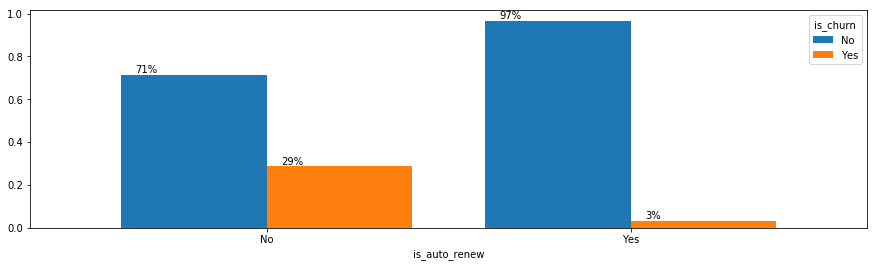

In [81]:
Auto_renew_crosstab=pd.crosstab(dataset['is_auto_renew'],dataset['is_churn'])
#Auto_renew_crosstab.plot(kind='bar', stacked=False, grid=False)
#Auto_renew_crosstab["Ratio"] =  Auto_renew_crosstab[1] / Auto_renew_crosstab[0]
Auto_renew_crosstab

ax = (Auto_renew_crosstab.div(Auto_renew_crosstab.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
ax.set_xticklabels(["No","Yes"], rotation = 0)
ax.legend(["No","Yes"], title = "is_churn")
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.10*width, p.get_y() + height + 0.01))
    

Auto_renew_crosstab

# Analysis of No.of Transactions variable

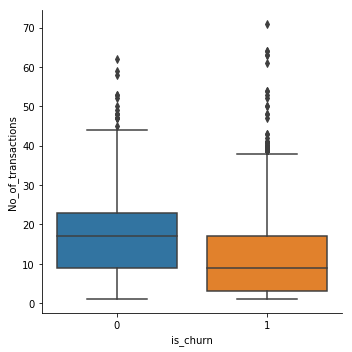

In [83]:
sns.catplot(x="is_churn", y="No_of_transactions", kind="box", data=dataset)

# Analysis of Age Variable

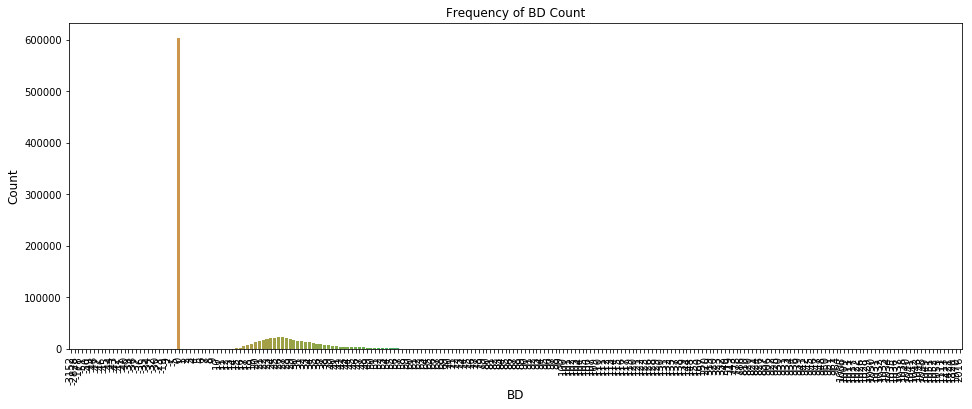

In [85]:
#Birth Date count in training Data Set
plt.figure(figsize=(16,6))
bd_order = dataset['bd'].unique()
bd_order = sorted(bd_order, key=lambda x: str(x))
bd_order = sorted(bd_order, key=lambda x: float(x))
#This is the only way I was able to diplay what I wanted
sns.countplot(x="bd", data=dataset , order = bd_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('BD', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of BD Count", fontsize=12)
plt.show()

In [86]:
dataset[dataset['bd'] > 120].count()            ## 135 count with values greater than 120 & 603358 < 0

No_of_transactions                135
is_churn                          135
payment_method_id                 135
plan_list_price                   135
actual_amount_paid                135
is_auto_renew                     135
is_cancel                         135
transaction_date                  135
membership_expire_date            135
city                              135
bd                                135
gender                            115
registered_via                    135
payment_plan_days                 135
registration_init_time            135
registration_init_time_weekday    135
lifetime                          135
membership_expire_date_month      135
transaction_date_month            135
dtype: int64

In [87]:
dataset['bd'] = dataset['bd'].astype(float)
dataset['bd'] = dataset.bd.apply(lambda x: -6000 if float(x)<=1 else x )  ## VAlues <1 are converted to -6000 value
dataset['bd'] = dataset.bd.apply(lambda x: -6000 if float(x)>=100 else x ) ## VAlues >100 are converted to -6000 value

Mean of Birth Date = 29.97192303441966
Median of Birth Date = 28.0


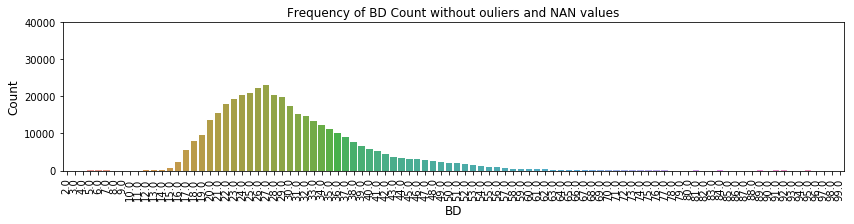

In [88]:
## Here is the frequency graph without outliers and nan values.
tmp_bd = dataset.loc[(dataset.bd.notna()) & (dataset.bd != -6000.0)]
print("Mean of Birth Date = " +str(np.mean(tmp_bd['bd'])))
print("Median of Birth Date = " +str(np.median(tmp_bd['bd'])))
plt.figure(figsize=(14,6))
ax1 = plt.subplot(211)
ax1.set_ylim( [0,40000] )
bd_order_2 = tmp_bd['bd'].unique()
bd_order_2 = sorted(bd_order_2, key=lambda x: float(x))
sns.countplot(x="bd", data=tmp_bd , order = bd_order_2)
plt.ylabel('Count', fontsize=12)
plt.xlabel('BD', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of BD Count without ouliers and NAN values", fontsize=12)
plt.show()

Distribution of Age i.e bd variable after removing outliers is positively right skewed.

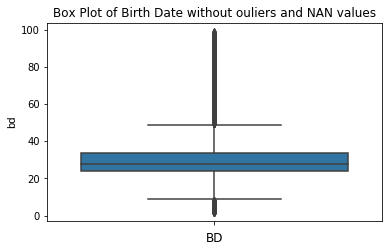

In [89]:
# Box plot to checkout the statistics of the Age variable
plt.figure(figsize=(6,8))
plt.subplot(212)
dataset.bd  = dataset.bd.astype(np.float)
sns.boxplot(y=tmp_bd["bd"],data=tmp_bd)
plt.xlabel('BD', fontsize=12)
plt.title("Box Plot of Birth Date without ouliers and NAN values", fontsize=12)
plt.show()

#### Bar plot of "is_churn" and "is_cancel" variables

is_churn,0,1
is_cancel,,
0,929456,63450
1,4,21


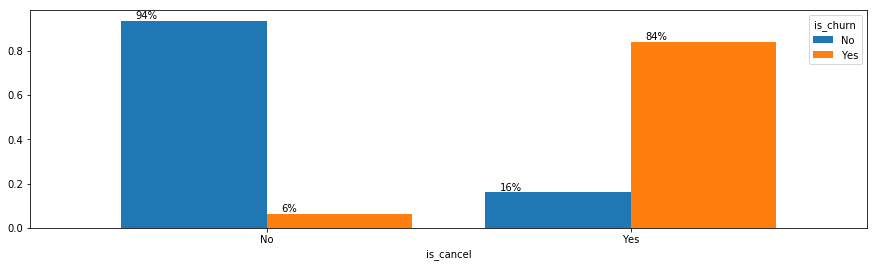

In [90]:
is_cancel_crosstab=pd.crosstab(dataset['is_cancel'],dataset['is_churn'])

ax = (is_cancel_crosstab.div(is_cancel_crosstab.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
ax.set_xticklabels(["No","Yes"], rotation = 0)
ax.legend(["No","Yes"], title = "is_churn")
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.10*width, p.get_y() + height + 0.01))
    

is_cancel_crosstab

We have very less data for members who canceled their subscription,so its hard to make any conclusion. we need to do more analyis here. 

#### Bar plot of "is_cancel" and "is_auto_renew" variables

is_auto_renew,0,1
is_cancel,,
0,117353,875553
1,0,25


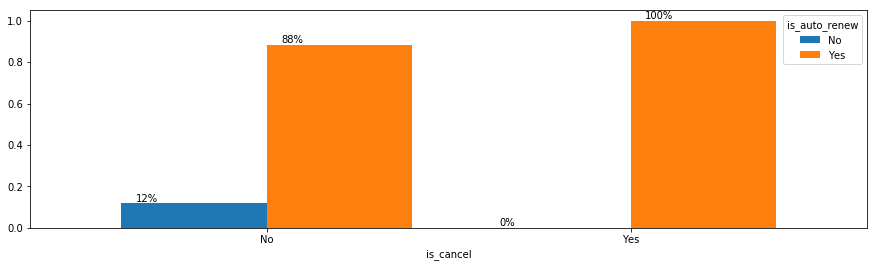

In [91]:
is_cancel_crosstab1 = pd.crosstab(dataset['is_cancel'],dataset['is_auto_renew'])

ax = (is_cancel_crosstab1.div(is_cancel_crosstab1.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
ax.set_xticklabels(["No","Yes"], rotation = 0)
ax.legend(["No","Yes"], title = "is_auto_renew")
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.10*width, p.get_y() + height + 0.01))
    

is_cancel_crosstab1

Again here very less data to make any strong conclusion.

#### Bar plot of "is_churn" and "gender" variables

is_churn,0,1
gender,,
female,169395,16013
male,188039,18245


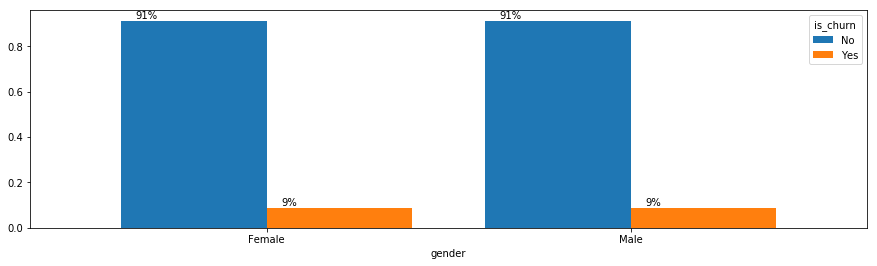

In [92]:
gender_crosstab=pd.crosstab(dataset['gender'],dataset['is_churn'])
ax = (gender_crosstab.div(gender_crosstab.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
ax.set_xticklabels(["Female","Male"], rotation = 0)
ax.legend(["No","Yes"], title = "is_churn")
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.10*width, p.get_y() + height + 0.01))
    

gender_crosstab

"Gender" doesn't have any effect on churning rate.

#### Bar plot of "is_churn" and "registered_via" variables

is_churn,0,1
registered_via,,
13,3447,375
3,99822,14284
4,49467,10701
7,545630,16274
9,231094,21837


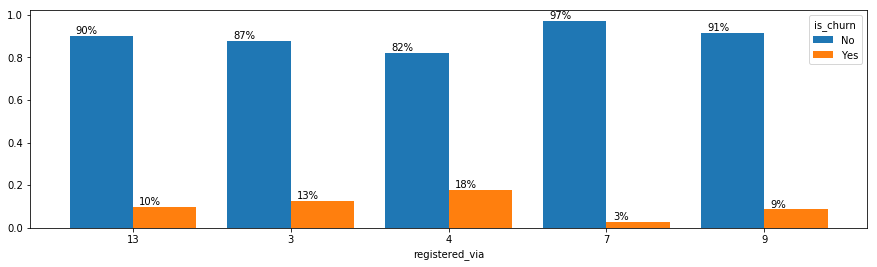

In [93]:
registered_via_crosstab=pd.crosstab(dataset['registered_via'],dataset['is_churn'])

ax = (registered_via_crosstab.div(registered_via_crosstab.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
ax.set_xticklabels(["13","3","4","7","9"], rotation = 0)
ax.legend(["No","Yes"], title = "is_churn")
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.10*width, p.get_y() + height + 0.01))
    
registered_via_crosstab

#### Frequency Plot of "Payment_method_id"  Variable

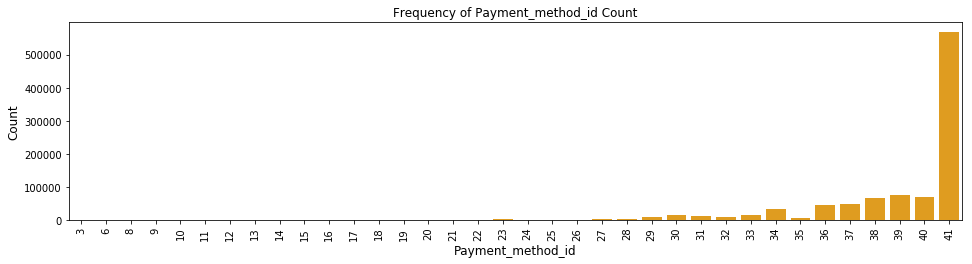

payment_method_id Count [(41, 569111), (39, 75621), (40, 69283), (38, 67527), (37, 49981), (36, 44752), (34, 34417), (30, 15875), (33, 15216), (31, 13491), (29, 8623), (32, 8130), (35, 7326), (28, 2307), (27, 1963), (23, 1854), (19, 1379), (21, 963), (22, 746), (18, 665), (20, 645), (17, 645), (14, 546), (26, 454), (24, 368), (16, 364), (25, 277), (12, 135), (13, 115), (11, 75), (10, 36), (15, 15), (8, 15), (3, 6), (6, 4), (9, 1)]


In [94]:
plt.figure(figsize=(16,8))
plt.subplot(211)
sns.countplot(x= "payment_method_id" ,data = dataset,  color="orange")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Payment_method_id', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Payment_method_id Count", fontsize=12)
plt.show()
payment_method_id_count = Counter(dataset['payment_method_id']).most_common()
print("payment_method_id Count " +str(payment_method_id_count))

#### Frequency Plot of "Payment_Plan_Days"  Variable

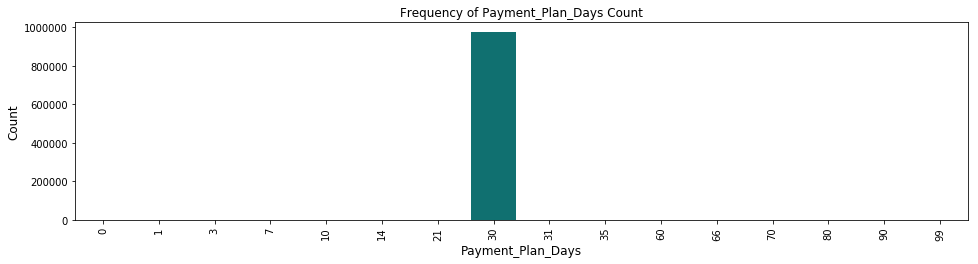

In [95]:
plt.figure(figsize=(16,8))
plt.subplot(211)
#days = dataset['payment_plan_days'].unique()
#days=sorted(days, key=lambda x: str(x))
plan_days = dataset[(dataset['payment_plan_days'] <100)]
sns.countplot(x= "payment_plan_days" ,data = plan_days,  color="teal")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Payment_Plan_Days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Payment_Plan_Days Count", fontsize=12)
plt.show()
#df[df.T[(df.T > 0.33)].any()]
#payment_plan_days_count = Counter(dataset['payment_plan_days']).most_common()
#print("Payment_plan_days Count " +str(payment_plan_days_count))

#### Frequency Plot of "Plan_List_Price"  Variable

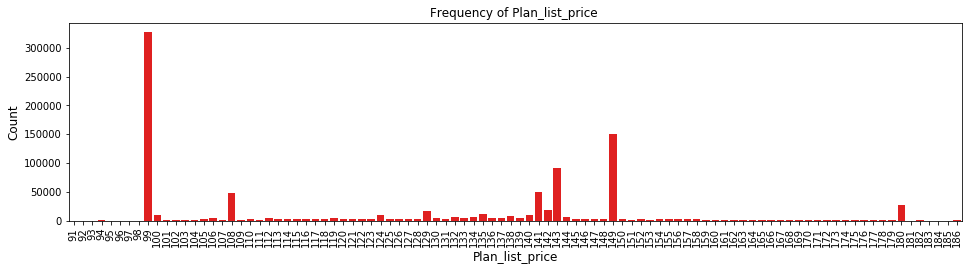

In [96]:
plt.figure(figsize=(16,8))
plt.subplot(211)
list_price = dataset[(dataset["plan_list_price"]< 187) & (dataset["plan_list_price"] > 90)]
sns.countplot(x= "plan_list_price",data = list_price,  color="red")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Plan_list_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Plan_list_price ", fontsize=12)
plt.show()
#plan_list_price_count = Counter(dataset['plan_list_price']).most_common()
#print("plan_list_price Count " +str(plan_list_price_count))

#### Frequency Plot of "Actual_amount_paid"  Variable

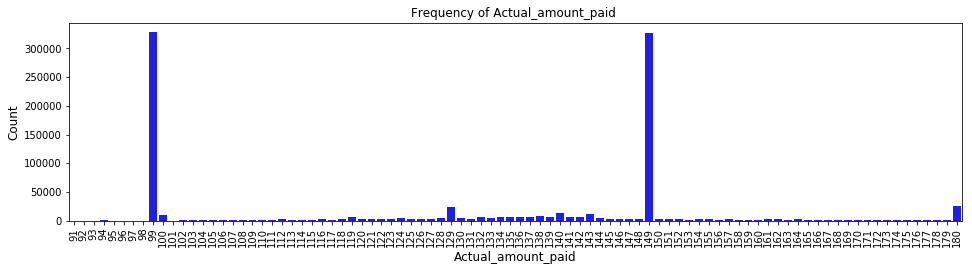

In [97]:
plt.figure(figsize=(16,8))
plt.subplot(211)
amount_paid = dataset[(dataset["actual_amount_paid"]< 181)& (dataset["actual_amount_paid"] > 90)]
sns.countplot(x= "actual_amount_paid" ,data = amount_paid,  color="blue")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Actual_amount_paid', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Actual_amount_paid ", fontsize=12)
plt.show()
#actual_amount_paid_count = Counter(dataset['actual_amount_paid']).most_common()
#print("actual_amount_paid Count " +str(actual_amount_paid_count))

#### Frequency Plot of "Registered_via"  Variable

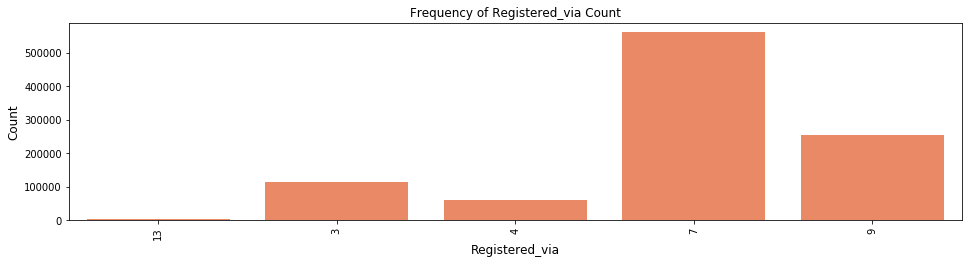

Registered_Via Count [('7', 561904), ('9', 252931), ('3', 114106), ('4', 60168), ('13', 3822)]


In [98]:
plt.figure(figsize=(16,8))
plt.subplot(211)
sns.countplot(x= "registered_via" ,data = dataset,  color="coral")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered_via', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Registered_via Count", fontsize=12)
plt.show()
registered_via_count = Counter(dataset['registered_via']).most_common()
print("Registered_Via Count " +str(registered_via_count))

#### Frequency Plot of "City"  Variable

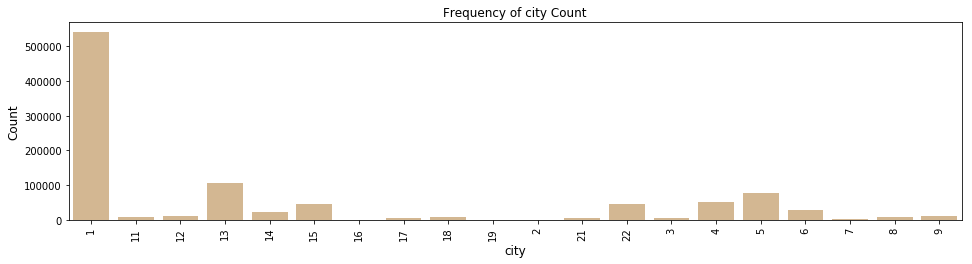

city Count [('1', 541332), ('13', 106332), ('5', 77546), ('4', 52301), ('15', 47086), ('22', 45851), ('6', 28427), ('14', 21943), ('12', 12659), ('9', 10353), ('11', 9878), ('18', 8568), ('8', 8400), ('17', 6086), ('21', 5813), ('3', 5520), ('7', 2880), ('16', 1050), ('2', 752), ('19', 154)]


In [99]:
plt.figure(figsize=(16,8))
plt.subplot(211)
sns.countplot(x= "city" ,data = dataset,  color="burlywood")
plt.ylabel('Count', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of city Count", fontsize=12)
plt.show()
city_count = Counter(dataset['city']).most_common()
print("city Count " +str(city_count))

#### Frequency Plot of "Gender"  Variable

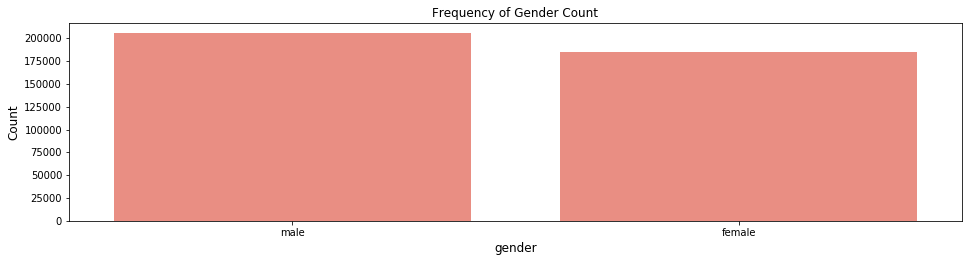

gender Count [(nan, 601239), ('male', 206284), ('female', 185408)]


In [100]:
plt.figure(figsize=(16,8))
plt.subplot(211)
sns.countplot(x= "gender" ,data = dataset,  color="salmon")
plt.ylabel('Count', fontsize=12)
plt.xlabel('gender', fontsize=12)
plt.xticks(rotation='horizontal')
plt.title("Frequency of Gender Count", fontsize=12)
plt.show()
gender_count = Counter(dataset['gender']).most_common()
print("gender Count " +str(gender_count))

#### Frequency Plot of "Yearly Trend of registration_init_time"  Variable

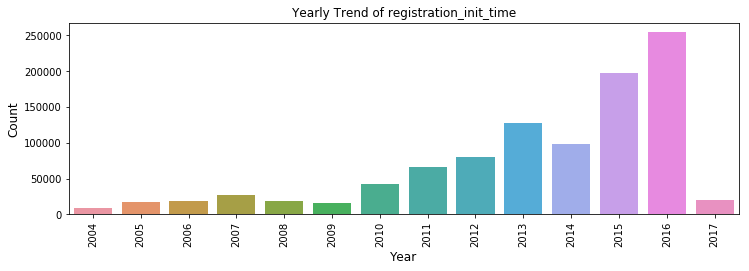

Yearly Count [(2016, 254576), (2015, 196551), (2013, 128063), (2014, 97536), (2012, 79960), (2011, 66483), (2010, 42185), (2007, 27531), (2017, 20691), (2006, 19095), (2008, 18286), (2005, 16915), (2009, 16354), (2004, 8705)]


In [101]:
# #registration_init_time yearly trend
dataset['registration_init_time_year'] = pd.DatetimeIndex(dataset['registration_init_time']).year
dataset['registration_init_time_year'] = dataset.registration_init_time_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
year_count=dataset['registration_init_time_year'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(311)
year_order = dataset['registration_init_time_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(year_count.index, year_count.values,order=year_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of registration_init_time", fontsize=12)
plt.show()
year_count_2 = Counter(dataset['registration_init_time_year']).most_common()
print("Yearly Count " +str(year_count_2))


#### Frequency Plot of "Monthly Trend of registration_init_time"  Variable

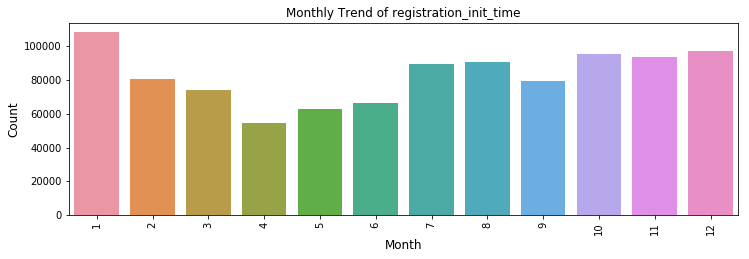

Monthly Count [(1, 108226), (12, 97035), (10, 95105), (11, 93815), (8, 90836), (7, 89591), (2, 80841), (9, 79651), (3, 74010), (6, 66558), (5, 62576), (4, 54687)]


In [102]:
# #registration_init_time monthly trend
dataset['registration_init_time_month'] = pd.DatetimeIndex(dataset['registration_init_time']).month
dataset['registration_init_time_month'] = dataset.registration_init_time_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
month_count=dataset['registration_init_time_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = dataset['registration_init_time_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(month_count.index, month_count.values,order=month_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of registration_init_time", fontsize=12)
plt.show()
month_count_2 = Counter(dataset['registration_init_time_month']).most_common()
print("Monthly Count " +str(month_count_2))

#### Frequency Plot of "Daywise Trend of registration_init_time"  Variable

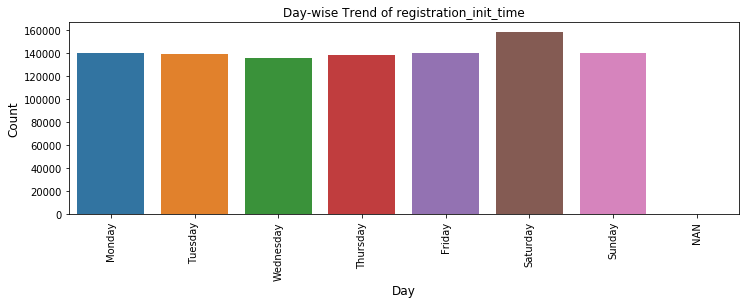

Day-wise Count [('Saturday', 158730), ('Friday', 140279), ('Monday', 140026), ('Sunday', 139801), ('Tuesday', 139263), ('Thursday', 138725), ('Wednesday', 136107)]


In [103]:
# #registration_init_time day wise trend
dataset['registration_init_time_weekday'] = pd.DatetimeIndex(dataset['registration_init_time']).weekday_name
dataset['registration_init_time_weekday'] = dataset.registration_init_time_weekday.apply(lambda x: str(x) if pd.notnull(x) else "NAN" )
day_count=dataset['registration_init_time_weekday'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(313)
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','NAN']
sns.barplot(day_count.index, day_count.values,order=day_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Day-wise Trend of registration_init_time", fontsize=12)
plt.show()
day_count_2 = Counter(dataset['registration_init_time_weekday']).most_common()
print("Day-wise Count " +str(day_count_2))

#### Creation of New Variable "Lifetime of Customers"

In [104]:
def month_diff(d1, d2): 
    """Return the number of months between d1 and d2, 
    such that d2 + month_diff(d1, d2) == d1
    """
    diff = (12 * d1.year + d1.month) - (12 * d2.year + d2.month)
    return diff
dataset['lifetime'] = month_diff(pd.DatetimeIndex(dataset['membership_expire_date']), pd.DatetimeIndex(dataset['registration_init_time']))

In [105]:
month_avg=dataset['lifetime'].mean()
print(month_avg)

40.25179896689699


The average lifetime of customers is 40 months~ 3yrs+4months 

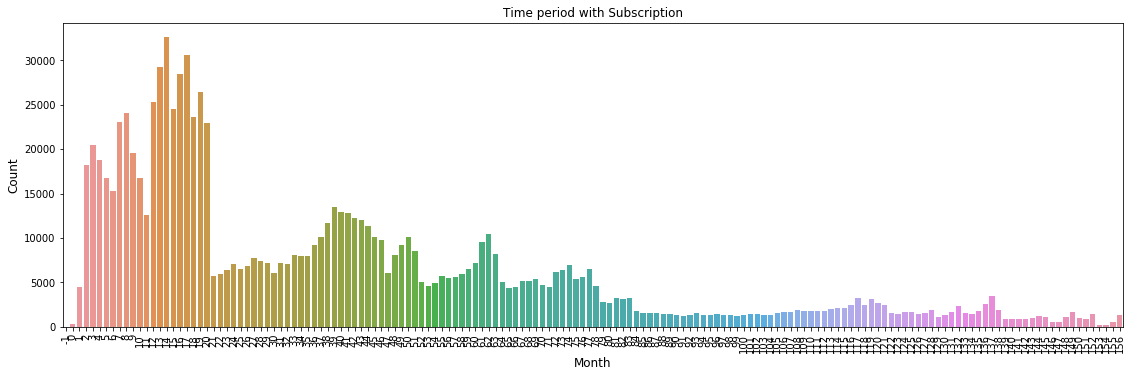

Monthly Count [(14, 32596), (17, 30643), (13, 29233), (16, 28494), (19, 26405), (12, 25358), (15, 24530), (8, 24051), (18, 23593), (7, 23079), (20, 22948), (3, 20470), (9, 19583), (4, 18808), (2, 18177), (10, 16785), (5, 16763), (6, 15342), (39, 13430), (40, 12954), (41, 12832), (11, 12620), (42, 12224), (43, 11976), (38, 11657), (44, 11364), (62, 10456), (50, 10107), (37, 10087), (45, 10051), (46, 9792), (61, 9489), (49, 9163), (36, 9151), (51, 8537), (63, 8171), (33, 8035), (48, 8031), (34, 7982), (35, 7933), (27, 7710), (28, 7418), (29, 7225), (60, 7218), (31, 7202), (32, 7117), (24, 7097), (74, 6972), (26, 6828), (77, 6486), (59, 6477), (25, 6449), (23, 6401), (73, 6366), (72, 6154), (30, 6071), (47, 6055), (22, 5982), (58, 5903), (21, 5760), (55, 5758), (57, 5636), (76, 5587), (56, 5520), (69, 5384), (75, 5350), (67, 5131), (68, 5090), (52, 5065), (64, 5003), (54, 4972), (70, 4691), (78, 4600), (53, 4542), (71, 4473), (1, 4429), (66, 4427), (65, 4389), (137, 3436), (81, 3235), (11

In [106]:
month_count=dataset['lifetime'].value_counts()
plt.figure(figsize=(19,19))
plt.subplot(313)
sns.barplot(month_count.index, month_count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Time period with Subscription", fontsize=12)
plt.show()
month_count_2 = Counter(dataset['lifetime']).most_common()
print("Monthly Count " +str(month_count_2))

#### Bar plot of "is_churn" and "membership_expire_date_month" variables

is_churn,0,1
membership_expire_date_month,,
2,44816,46929
3,884644,16542


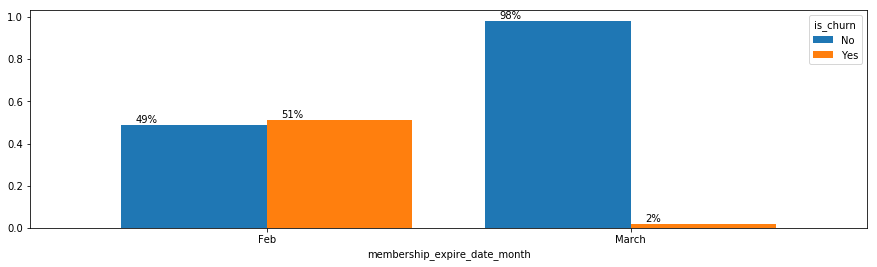

In [107]:
dataset['membership_expire_date_month'] = pd.DatetimeIndex(dataset['membership_expire_date']).month
membership_expire_date_crosstab=pd.crosstab(dataset['membership_expire_date_month'],dataset['is_churn'])

ax = (membership_expire_date_crosstab.div(membership_expire_date_crosstab.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
ax.set_xticklabels(["Feb","March"], rotation = 0)
ax.legend(["No","Yes"], title = "is_churn")
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.10*width, p.get_y() + height + 0.01))
    
membership_expire_date_crosstab

We can see here the members whose membership expires in the month of march has lower churn rate.

#### Frequency Plot of "Monthly Trend of transaction_date"  Variable

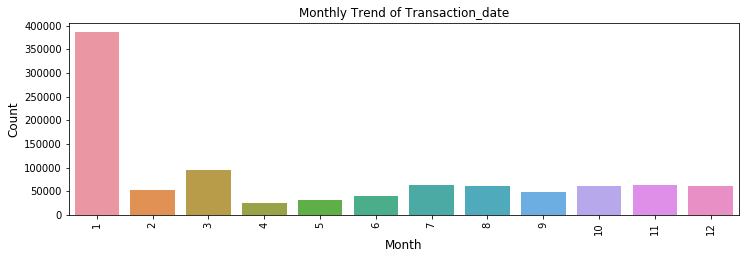

Monthly Count [(1, 386256), (3, 95604), (7, 63767), (11, 62789), (8, 62348), (10, 61739), (12, 60813), (2, 52195), (9, 48734), (6, 39893), (5, 32419), (4, 26374)]


In [108]:
# #transaction_date monthly trend
dataset['transaction_date_month'] = pd.DatetimeIndex(dataset['transaction_date']).month
dataset['transaction_date_month'] = dataset.transaction_date_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
month_count=dataset['transaction_date_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = dataset['transaction_date_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(month_count.index, month_count.values,order=month_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of Transaction_date", fontsize=12)
plt.show()
month_count_2 = Counter(dataset['transaction_date_month']).most_common()
print("Monthly Count " +str(month_count_2))

## Observations:- 
- On average, about 97% members who put auto_renewal for their payments are less likely to get churned.
- About 88% people who are on auto_renewal,are more likely to renew their subcriptions.
- On average, about 88% people put their payments on Auto_renewal.
- No effect of gender, registred_via on churn rate.
- In the last 4-5 years,there is more increase in subcription rate.
- Large amount of observations are from city-1.
- About 59% people used registered via technique number-7 used 41-category method-id to make payments.
- More new registrations at the start and end of the year
- About 93% people enrolled in 30 days payment plan.
- On average, the lifetime of a customer who stays with subscription is nearly 40 months.
- Most of people opted $99 price plan and paid actual amount. 
- On weekends there are more new registrations for the subscription.
- Membership expires mainly in starting months of the year till march and seems like very less churn rate in month of March.
- There are more transactions in the month of January,this may be due to more new subscription plans are available. 

# Infrential Statistics Part

#### Correlation graph between various variables

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

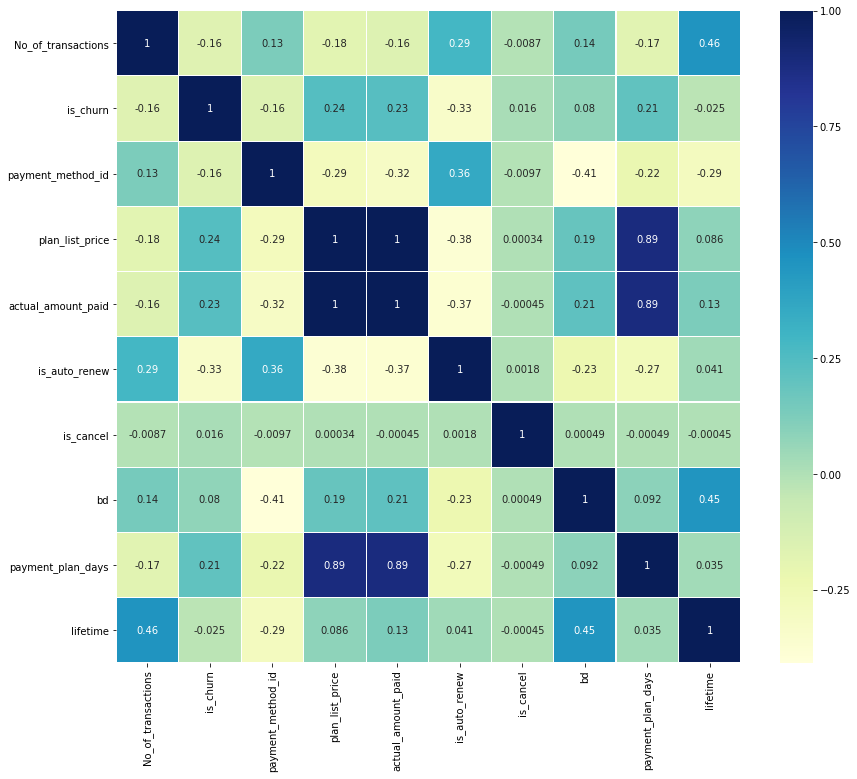

In [109]:
plt.figure(figsize=(14,12))
data_plot = dataset.drop(["membership_expire_date","registration_init_time_year","registration_init_time_month","registration_init_time_weekday",
                          "membership_expire_date_month","transaction_date_month"],axis =1)
sns.heatmap(data_plot.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)

- We can see from above Graph, There is strong correlation between payment plan days, actual_amount paid, plan list price features. 
- Relationship between No. of transactions and Lifetime of customer, means more the no. of transactions, more likely the customer will continue with the subscription. 
- Also is_churn and is_auto_renewal are negatively correlated to each other. 

## Inferential Statistics

- We want to check is there any relationship between 
   - is_auto_renew and is_churn /
   - is_cancel and is_churn.
   - We will be using Chi-Squared test to check the association between these variables.

# First let's take a look towards the Assumptions:

- Our data is pretty much random and is good representation of the population
- The variables under study are categorical. 
- The expected value of the number of sample observations at each level of the variable is more than 5.

#### The Null and Alternate Hypotheses:-
- Recall that we are interested in knowing if there is a relationship between 'is_churn' and 'is_auto_renew'. 
- In order to do so, we will use the Chi-squared test and set our significance level to be 0.05 .But first, let's state our null hypothesis and the alternative hypothesis.

- H0:There is no statistically significant relationship between 'is_churn' and 'is_auto_renew'
- Ha:There is a statistically significant relationship between 'is_churn' and 'is_auto_renew'

#### Constructing the Contingency Table
- The next step is to format the data into a frequency count table.
- This is called a Contingency Table, we can accomplish this by using the pd.crosstab() function in pandas.

In [110]:
contingency_table = pd.crosstab(
     dataset['is_churn'],
     dataset['is_auto_renew'],
     margins = True)
contingency_table

is_auto_renew,0,1,All
is_churn,,,
0,83706,845754,929460
1,33647,29824,63471
All,117353,875578,992931


In [111]:
f_obs = np.array([contingency_table.iloc[0][0:2].values,
                   contingency_table.iloc[1][0:2].values])
print(f_obs)
from scipy import stats
stats.chi2_contingency(f_obs)[0:3]

[[ 83706 845754]
 [ 33647  29824]]


(110392.11882460065, 0.0, 1)

- Chisq_test_statistic = 632301.26, P-value ~ 0, degree_of_freedom = 1
#### Conclusions:- 

- With a p-value < 0.05 , we can reject the null hypothesis. There is definitely some sort of statistically significant relationship between 'is_churn' and the 'is_auto_renew' column.
- We don't know what this relationship is, but we do know that these two variables are not independent of each other.

#### Relationship between 'is_churn' and 'is_cancel' Variables

The Null and Alternate Hypotheses:-
- Recall that we are interested in knowing if there is a relationship between 'is_churn' and 'is_cancel'. In order to do so, - we would have to use the Chi-squared test and we set our significance level to be 0.05 .But first, let's state our null hypothesis and the alternative hypothesis.

- H0:There is no statistically significant relationship between 'is_churn' and 'is_cancel'
- Ha:There is a statistically significant relationship between 'is_churn' and 'is_cancel'

In [112]:
contingency_table1 = pd.crosstab(
    dataset['is_churn'],
    dataset['is_cancel'],
    margins = True)
contingency_table1

is_cancel,0,1,All
is_churn,,,
0,929456,4,929460
1,63450,21,63471
All,992906,25,992931


In [113]:
f_obs1 = np.array([contingency_table1.iloc[0][0:2].values,
                  contingency_table1.iloc[1][0:2].values])
print(f_obs1)
from scipy import stats
stats.chi2_contingency(f_obs1)[0:3]

[[929456      4]
 [ 63450     21]]


(238.84449751553225, 7.025206995546444e-54, 1)

- Chisq_test_statistic = 56664.17, P-value ~ 0, degree_of_freedom = 1
#### Conclusions:- 

- With a p-value < 0.05 , we can reject the null hypothesis. There is definitely some sort of statistically significant relationship between 'is_churn'  and the 'is_cancel' column.
- We don't know what this relationship is, but we do know that these two variables are not independent of each other.

## Logistic Regression

Need to check whether our "is_churn" output feature is balanced or not? 

In [114]:
count_no_churn = len(dataset[dataset['is_churn']==0])
count_churn = len(dataset[dataset['is_churn']==1])
pct_of_no_churn = count_no_churn/(count_no_churn+count_churn)
print("percentage of no churn is", pct_of_no_churn*100)
pct_of_churn = count_churn/(count_no_churn+count_churn)
print("percentage of churn", pct_of_churn*100)

percentage of no churn is 93.60771292265021
percentage of churn 6.392287077349786


This is an Unbalanced class. Before we try to make it a balanced class, Let's create the dummy variables of the categorical features.

In [115]:
# Creating dummy variables for categorical datatypes
datasetDummies = pd.get_dummies(dataset, columns=['gender', 'payment_method_id', 'payment_plan_days', 'is_auto_renew','is_cancel',
                                              'registered_via','city'])

In [116]:
y = datasetDummies.iloc[:,1]
y.head()

msno
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=    0
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=    0
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=    0
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=    0
++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=    0
Name: is_churn, dtype: int64

In [117]:
X = datasetDummies[['No_of_transactions',
 'plan_list_price',
 'actual_amount_paid',
 'bd','lifetime','gender_male','payment_method_id_39',
 'payment_method_id_40',
 'payment_method_id_41','payment_plan_days_30','is_auto_renew_1','is_cancel_1',
 'registered_via_3',
 'registered_via_7',
 'registered_via_9',
 'city_1','city_13', 'city_5']]

In [118]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992931 entries, +++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o= to zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=
Data columns (total 18 columns):
No_of_transactions      992931 non-null int64
plan_list_price         992931 non-null int64
actual_amount_paid      992931 non-null int64
bd                      992931 non-null float64
lifetime                992931 non-null int64
gender_male             992931 non-null uint8
payment_method_id_39    992931 non-null uint8
payment_method_id_40    992931 non-null uint8
payment_method_id_41    992931 non-null uint8
payment_plan_days_30    992931 non-null uint8
is_auto_renew_1         992931 non-null uint8
is_cancel_1             992931 non-null uint8
registered_via_3        992931 non-null uint8
registered_via_7        992931 non-null uint8
registered_via_9        992931 non-null uint8
city_1                  992931 non-null uint8
city_13                 992931 non-null uint8
city_5                  99293

#### Let's Use SMOTE for balancing the Minority class of "Churn"
(Synthetic Minority Over-sampling Technique)
SMOTE is an over-sampling method.It creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records.

In [119]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

In [120]:
 # Dividing data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (695051, 18)
Number transactions y_train dataset:  (695051,)
Number transactions X_test dataset:  (297880, 18)
Number transactions y_test dataset:  (297880,)


In [121]:
print("Before OverSampling, counts of label Churn: {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label No_churn: {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label Churn: {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label No_churn: {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label Churn: 44464
Before OverSampling, counts of label No_churn: 650587 

After OverSampling, the shape of train_X: (1301174, 18)
After OverSampling, the shape of train_y: (1301174,) 

After OverSampling, counts of label Churn: 650587
After OverSampling, counts of label No_churn: 650587


Both categories have equal amount of records. 
More specifically, the minority class has been increased to the total number of majority class.

#### LOGISTIC REGRESSION 
It is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (Churn) or 0 (non-churn).In other words, the logistic regression model predicts P(Y=1) as a function of X.

I used GridSearchCV method to tune the regularization hyperparameter'C'.Regularization is used to prevent the model from overfitting the data.Here in this Method all of the possible combinations of parameter values are evaluated and the best combination is retained.

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  7.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [123]:
clf.best_params_

{'C': 7.0}

In [124]:
lr1 = LogisticRegression(C=7,penalty='l1', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(C=7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=5, warm_start=False)

In [125]:
print('Intercept: ' + str(lr1.intercept_))
print('Regression: ' + str(lr1.coef_))

Intercept: [3.4577319]
Regression: [[-1.19947374e-02  1.11602255e-02 -1.08945852e-02 -2.13189371e-05
   4.76075987e-04 -9.10197314e-03  1.46804629e-01  3.50644850e-01
  -8.90570615e-03 -1.43719218e+00 -2.01574896e+00  6.48054738e+00
  -3.28709100e-01 -7.71205449e-01 -4.85011057e-01 -8.21372886e-02
  -1.01879473e-01 -1.08802539e-01]]


In [126]:
y_train_pred = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pred)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


Recall metric in the train dataset: 57.680370636919754%


In [127]:
y_pred = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix :\n",cnf_matrix)
print( "Accuracy Score :",accuracy_score(y_test, y_pred))
print("Classification Report :\n",classification_report(y_test, y_pred))
#print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

Confusion Matrix :
 [[246699  32174]
 [  8125  10882]]
Accuracy Score : 0.8647139787834027
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.88      0.92    278873
           1       0.25      0.57      0.35     19007

   micro avg       0.86      0.86      0.86    297880
   macro avg       0.61      0.73      0.64    297880
weighted avg       0.92      0.86      0.89    297880



The result is telling us that (246698+10889) = 257587 are correct predictions and (32175+8118) = 40293 are incorrect predictions.

In [128]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

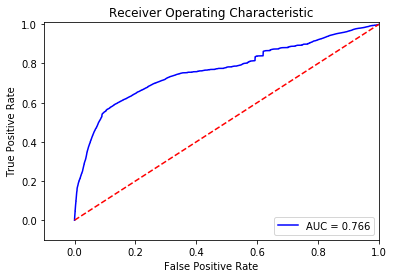

In [129]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [130]:
roc_auc

0.766286353508995

 AUC-ROC Curve - 
 It is one of the most important evaluation metrics for checking any classification model’s performance.ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. 
By analogy, Higher the AUC, better the model is at distinguishing between churn and no_churn
Here AUC = 77% which is good. 

#### TREE BASED ALGORITHMS
#### Decision Trees
A decision tree is a supervised learning method that makes a prediction by learning simple decision rules from the explanatory variables. 
<br>
Decision trees have the following advantages:
<br>
Trees can be visualised, which makes them easy to interpret
<br>
They can handle numerical and categorical data
<br>
We can easily validate the model using statistical tests
<br>
The downsides to decision trees:
<br>
Decision trees are very prone to overfitting the training data, and often do not generalise well.
<br>
Small variations in the training data can cause a completely different tree to be generated.
<br>
Decision tree learning algorithms are based on heuristic algorithms like the greedy algorithm, which make locally optimal decisions at each node. These algorithms cannot guarantee a globally optimal decision tree.
<br>
<br>
Decision trees can be a good starting point for developing predictive models that generalise better, like random forests.

In [131]:
# Spliting into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=24)

In [132]:

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.set_params(min_samples_leaf=3)
clf.set_params(max_depth=4)
clf = clf.fit(X_train,y_train)

In [133]:
print('Accuracy of decision tree classifier on test set: {:.2f}'.format(clf.score(X_test,y_test)))

Accuracy of decision tree classifier on test set: 0.94


In [134]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/sucha/OneDrive/Desktop/graphinviz/release/bin'
from sklearn.tree import export_graphviz
import graphviz

In [135]:
churnTree = tree.export_graphviz(clf, out_file=None, 
                         feature_names = list(X_train.columns.values),  
                         class_names = ['No_churn', 'Churn'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(churnTree)
graph.render('decision_tree.gv', view=True)

'decision_tree.gv.pdf'

In [136]:
from sklearn.externals.six import StringIO
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
!dot -Tpng tree.dot > tree.png

#### Random Forest 
Random forests are an ensemble learning method, where the results from multiple decision trees are combined to make a final prediction. For example, a random forest may be made up of 10 decision trees, 7 of which make a prediction for ‘churn’ and 3 of which make a prediction for ‘no churn’. The final prediction for the forest will be ‘churn’.

In [137]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train,y_train)
# Predicting the test set results
y_Pred_rf = rf_classifier.predict(X_test)

In [138]:
print(y_Pred_rf.sum())

8411


In [139]:
# Making the Confusion Matrix and classification report
cm = confusion_matrix(y_test, y_Pred_rf)
cr = classification_report(y_test, y_Pred_rf)

In [140]:
print("Confusion Matrix :\n",cm)
print("Classification Report :\n",cr)
print("Accuracy :",rf_classifier.score(X_test, y_test))

Confusion Matrix :
 [[228989   3402]
 [ 10833   5009]]
Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.99      0.97    232391
           1       0.60      0.32      0.41     15842

   micro avg       0.94      0.94      0.94    248233
   macro avg       0.78      0.65      0.69    248233
weighted avg       0.93      0.94      0.93    248233

Accuracy : 0.9426546833015755


#### Feature Importance Plot

In [148]:
feature_importances = pd.DataFrame(rf_classifier.feature_importances_[:],
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

                      importance
lifetime                0.285956
No_of_transactions      0.186853
bd                      0.123519
plan_list_price         0.099262
actual_amount_paid      0.093666
is_auto_renew_1         0.092885
payment_plan_days_30    0.021375
registered_via_7        0.016978
payment_method_id_41    0.014871
gender_male             0.013292
city_13                 0.010449
city_5                  0.009478
city_1                  0.008425
registered_via_9        0.007440
registered_via_3        0.006591
payment_method_id_40    0.004431
payment_method_id_39    0.004363
is_cancel_1             0.000164


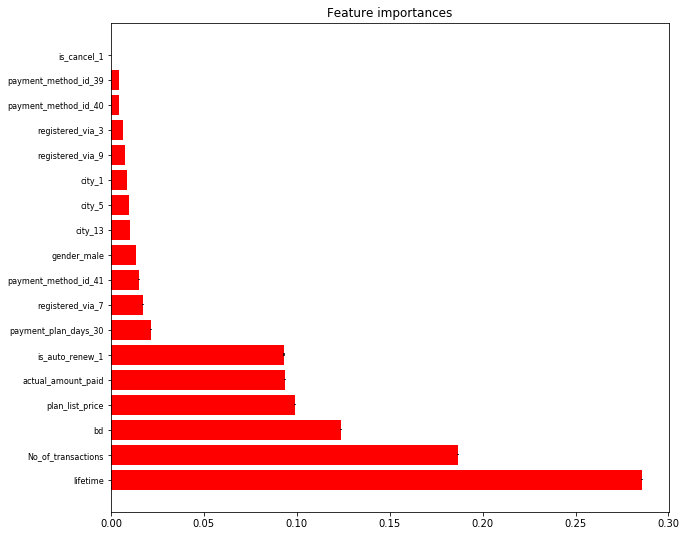

In [141]:
#Implementation of feature importance plot

importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(10,9))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(X_train.shape[1]), names, fontsize = 8)
plt.show()


From my analysis the fetaures lifetime, bd ,No.of transactions, plan_list_price, is_auto_renew_1 are important features for determining the behavior of customer_churn. So we should keep them in mind and share insights with our customer success team and adapt their focus.